In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from astropy.table import Table

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
tab = Table.read('3dhst_master.phot.v4.1.csv', format='ascii').to_pandas()

## Preprocessing

In [3]:
tab = tab[tab.lmass > 9].copy()

target = 'z_spec'  # spectroscopic redshift
#features = [col for col in tab.columns if (col != target)]

tab['f_F125W_f_F140W'] = tab['f_F125W'] - tab['f_F140W']
tab['f_F125W_f_F160W'] = tab['f_F125W'] - tab['f_F160W']
tab['f_F125W_f_F606W'] = tab['f_F125W'] - tab['f_F606W']
tab['f_F125W_f_F814W'] = tab['f_F125W'] - tab['f_F814W']

tab['f_F140W_f_F160W'] = tab['f_F140W'] - tab['f_F160W']
tab['f_F140W_f_F606W'] = tab['f_F140W'] - tab['f_F606W']
tab['f_F140W_f_F814W'] = tab['f_F140W'] - tab['f_F814W']

tab['f_F160W_f_F606W'] = tab['f_F160W'] - tab['f_F606W']
tab['f_F160W_f_F814W'] = tab['f_F160W'] - tab['f_F814W']

tab['f_F606W_f_F814W'] = tab['f_F606W'] - tab['f_F814W']
features = [col for col in tab.columns if (col != target and col[0:3] == 'f_F' and col[-1] == 'W')]


features = [col for col in features if (col != 'Av') and (col != 'lmass') and (col != 'z_peak') 
            and (col != 'flags') and (col != 'f140w_flag') and (col != 'star_flag') 
            and (col != 'use_phot') and (col != 'near_star')]

tab = tab[(tab[target] > 0)].copy()

label_encoder = LabelEncoder()
tab['field'] = label_encoder.fit_transform(tab['field'])

errors = [col for col in features if (col[:1] == 'e') and (col[-1:] == 'W')]

for error in errors:
    tab[error] = np.where(tab[error] < -90, tab[error].median(), tab[error])

### Train test split

In [4]:
X = tab[features].values
y = tab[target].values

indices = np.arange(len(y))

# first reserve 70% of the data for training, 30% for validation
X_train, X_validate, y_train, y_validate, indices_train, indices_validate = train_test_split(X, y, indices, test_size=0.3, random_state=42)

# second, split the validation set in half to obtain validation and test sets. 
X_validate, X_test, y_validate, y_test, indices_validate, indices_test = train_test_split(X_validate, y_validate, indices_validate, test_size=0.5, random_state=42)

### Model

In [5]:
scaler = StandardScaler()
X_train    = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test     = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_validate_tensor = torch.tensor(X_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validate_dataset = TensorDataset(X_validate_tensor, y_validate_tensor)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32)
            outputs = self.forward(x_tensor)
            return outputs.numpy().flatten()
        
input_size = X_train.shape[1]
model = MLP(input_size)
criterion = nn.MSELoss() # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2000
train_losses = []
val_losses = []

In [7]:
best_val_loss = float('inf')
save_path = "best_model.pth"

for epoch in range(num_epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs) 
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validate_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(validate_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"✅ Best model saved at epoch {epoch+1} with val_loss={best_val_loss:.4f}")

Epoch [1/2000], Train Loss: 0.5309, Val Loss: 0.3798
✅ Best model saved at epoch 1 with val_loss=0.3798
Epoch [2/2000], Train Loss: 0.3351, Val Loss: 0.3432
✅ Best model saved at epoch 2 with val_loss=0.3432
Epoch [3/2000], Train Loss: 0.3212, Val Loss: 0.3310
✅ Best model saved at epoch 3 with val_loss=0.3310
Epoch [4/2000], Train Loss: 0.3069, Val Loss: 0.3198
✅ Best model saved at epoch 4 with val_loss=0.3198
Epoch [5/2000], Train Loss: 0.2921, Val Loss: 0.3078
✅ Best model saved at epoch 5 with val_loss=0.3078
Epoch [6/2000], Train Loss: 0.2839, Val Loss: 0.3226
Epoch [7/2000], Train Loss: 0.2770, Val Loss: 0.2961
✅ Best model saved at epoch 7 with val_loss=0.2961
Epoch [8/2000], Train Loss: 0.2960, Val Loss: 0.3015
Epoch [9/2000], Train Loss: 0.2714, Val Loss: 0.2753
✅ Best model saved at epoch 9 with val_loss=0.2753
Epoch [10/2000], Train Loss: 0.2643, Val Loss: 0.2765
Epoch [11/2000], Train Loss: 0.2533, Val Loss: 0.2691
✅ Best model saved at epoch 11 with val_loss=0.2691
Epoch 

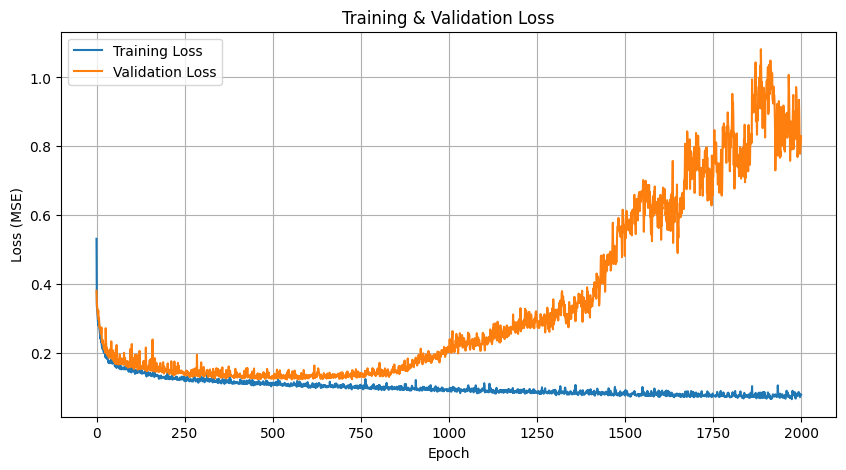

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
mlp = type(model)(input_dim=X_train.shape[1], hidden_dim=128)
mlp.load_state_dict(torch.load(save_path))
mlp.eval()

y_predict = mlp.predict(X_test)
print(f'MSE = {mean_squared_error(y_test, y_predict):.4f}')

MSE = 0.1303


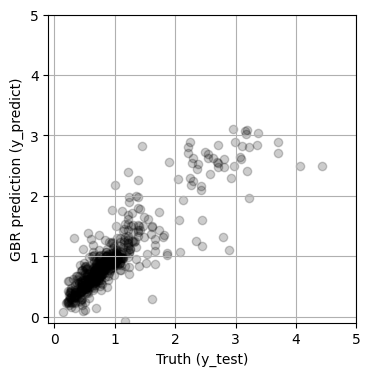

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, color='black')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('GBR prediction (y_predict)')
plt.show()

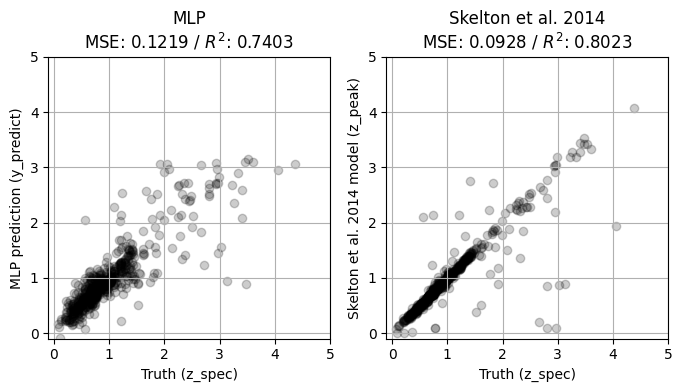

In [11]:
y_predict_validate = mlp.predict(X_validate)
y_skelton2014 = tab['z_peak'].values[indices_validate]

mse_mlp = mean_squared_error(y_validate, y_predict_validate)
r2_mlp = r2_score(y_validate, y_predict_validate)

mse_skelton = mean_squared_error(y_validate, y_skelton2014)
r2_skelton = r2_score(y_validate, y_skelton2014)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].scatter(y_validate, y_predict_validate, alpha=0.2, color='black')
ax[0].set_aspect('equal')
ax[0].set_xlim(-0.1, 5)
ax[0].set_ylim(-0.1, 5)
ax[0].grid()
ax[0].set_xlabel('Truth (z_spec)')
ax[0].set_ylabel('MLP prediction (y_predict)')
ax[0].set_title(f'MLP\nMSE: {mse_mlp:.4f} / $R^2$: {r2_mlp:.4f}')


ax[1].scatter(y_validate, y_skelton2014, alpha=0.2, color='black')
ax[1].set_aspect('equal')
ax[1].set_xlim(-0.1, 5)
ax[1].set_ylim(-0.1, 5)
ax[1].grid()
ax[1].set_xlabel('Truth (z_spec)')
ax[1].set_ylabel('Skelton et al. 2014 model (z_peak)')
ax[1].set_title(f'Skelton et al. 2014\nMSE: {mse_skelton:.4f} / $R^2$: {r2_skelton:.4f}')

plt.show()